## Домашнее задание № 4

Задание выполнил(а): Золотарев Антон Олегович

### Ансамблевые методы 

**Дедлайн: 3.06.2020 23:59** 
Сопровождайте код изображениями и комментариями. Не игнорируйте вопросы, ваши выводы тоже оцениваются. Чем больше информации вы сможете извлечь, аргументированных выводов сформулировать, тем лучше. Не забывайте подписывать графики и будет вам счастье!

**Максимальный балл: 10**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns


%matplotlib inline

**0. (0 баллов) ** Загрузите [датасет](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data), в нем вы найдете данные опрошенных женщин из индейского племени Пима. Будем решать задачу бинарной классификации: в колонке Outcome лежит метка наличия или отсутствия диабета - это наша целевая переменная. Есть ли пропущенные значения?

In [2]:
data = pd.read_csv('./diabetes.csv')

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**1. (0.5 балла)** Как вы думаете, является ли наличие нулей в некоторых колонках фактом того, что эти признаки имеют пропущенные значения? Замените нули на среднее значение признака там, где считаете это целесообразным.

Скорее всего, нули в столбцах "Глюкоза", "Давление", "Толщина кожи", "Инсулин", "Индекс массы тела" являются признаками пропущенного значения, поскольку если у человека хотя бы один из этих параметров действительно равен нулю, то вряд ли он будет жить больше одного дня. Количество беременностей вполне может быть нулевым, тогда как в остальных двух столбцах ("Родословная диабета" и "Возраст") нет пропусков.

In [3]:
for i in data.columns:
    print('Количество пропусков в ', i, ' составляет ', data[data[i]==0][i].count(), '.', '\n Доля пропусков в ', i, 
              ' составляет ', round(data[data[i]==0][i].count()/len(data[i]), 3), '.', '\n', sep='')

Количество пропусков в Pregnancies составляет 111.
 Доля пропусков в Pregnancies составляет 0.145.

Количество пропусков в Glucose составляет 5.
 Доля пропусков в Glucose составляет 0.007.

Количество пропусков в BloodPressure составляет 35.
 Доля пропусков в BloodPressure составляет 0.046.

Количество пропусков в SkinThickness составляет 227.
 Доля пропусков в SkinThickness составляет 0.296.

Количество пропусков в Insulin составляет 374.
 Доля пропусков в Insulin составляет 0.487.

Количество пропусков в BMI составляет 11.
 Доля пропусков в BMI составляет 0.014.

Количество пропусков в DiabetesPedigreeFunction составляет 0.
 Доля пропусков в DiabetesPedigreeFunction составляет 0.0.

Количество пропусков в Age составляет 0.
 Доля пропусков в Age составляет 0.0.

Количество пропусков в Outcome составляет 500.
 Доля пропусков в Outcome составляет 0.651.



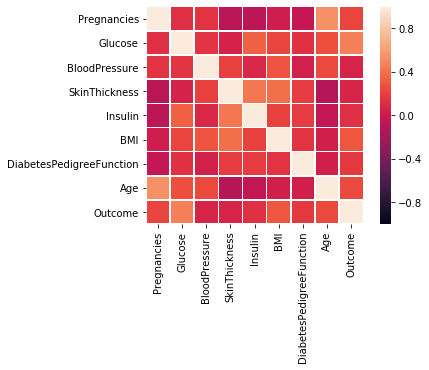

In [4]:
cor_mat = pd.DataFrame(data).corr()
sns.heatmap(cor_mat, vmin = -1, vmax = 1, linewidths = 0.5, square = True)

In [5]:
cor_mat[abs(cor_mat) > 0.35]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.544341,NaN
Glucose,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.466581
BloodPressure,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
SkinThickness,NaN,NaN,NaN,1.000000,0.436783,0.392573,NaN,NaN,NaN
Insulin,NaN,NaN,NaN,0.436783,1.000000,NaN,NaN,NaN,NaN
BMI,NaN,NaN,NaN,0.392573,NaN,1.000000,NaN,NaN,NaN
DiabetesPedigreeFunction,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
Age,0.544341,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
Outcome,NaN,0.466581,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Видно, что толщина кожи положительно коррелирует с уровнем инсулина и индексом массы тела. Это весьма важные свитедельства того, что если мы заполним все пропуски простым средним, то можем испортить итоговое качество классификации.

Учитывая малое количество пропусков в индексе массы тела, мы можем обучить регрессию для заполнения пропусков в толщине кожи. Оттуда найдём уровень инсулина и будем следить, чтобы взаимозависимость между переменными не испортилась.

Попробуем обучить деревья для эффективного заполнения пропусков средними значениями:

In [6]:
from sklearn.tree import DecisionTreeRegressor

In [7]:
col_names = data.columns
train_null_data = pd.DataFrame(columns = col_names)
for i in range(len(data)):
    #ставим такое условие, чтобы регрессия не обучалась на нулевых значениях
    if (data.iloc[i, 1:5]!=0).all():
        train_null_data = train_null_data.append(data.iloc[i, :], ignore_index=True)
train_null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
1,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
2,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1.0
3,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,1.0
4,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0,1.0


In [8]:
test_null_data = pd.DataFrame(columns = col_names)
for i in range(len(data)):
    if data.iloc[i, 3]==0:
        test_null_data = test_null_data.append(data.iloc[i, :], ignore_index=True)
test_null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1.0
1,5.0,116.0,74.0,0.0,0.0,25.6,0.201,30.0,0.0
2,10.0,115.0,0.0,0.0,0.0,35.3,0.134,29.0,0.0
3,8.0,125.0,96.0,0.0,0.0,0.0,0.232,54.0,1.0
4,4.0,110.0,92.0,0.0,0.0,37.6,0.191,30.0,0.0


In [9]:
#Заполним пропуски в "толщине кожи"
X_train_null_data = train_null_data.drop('SkinThickness', axis=1)
X_test_null_data = test_null_data.drop('SkinThickness', axis=1)
y_train_null_data = train_null_data['SkinThickness']
y_test_null_data = test_null_data['SkinThickness']

In [10]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train_null_data, y_train_null_data)
test_null_data['SkinThickness'] = regressor.predict(X_test_null_data)

In [11]:
test_null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,8.0,183.0,64.0,22.0,0.0,23.3,0.672,32.0,1.0
1,5.0,116.0,74.0,19.0,0.0,25.6,0.201,30.0,0.0
2,10.0,115.0,0.0,47.0,0.0,35.3,0.134,29.0,0.0
3,8.0,125.0,96.0,22.0,0.0,0.0,0.232,54.0,1.0
4,4.0,110.0,92.0,46.0,0.0,37.6,0.191,30.0,0.0


In [12]:
garbage_null_data = pd.DataFrame(columns = col_names)
for i in range(len(data)):
    if (((data.iloc[i, 1:3]==0).any() or (data.iloc[i, 4:5]==0).any()) and data.iloc[i, 3]!=0):
        garbage_null_data = garbage_null_data.append(data.iloc[i, :], ignore_index=True)
garbage_null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1.0
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0.0
2,9.0,119.0,80.0,35.0,0.0,29.0,0.263,29.0,1.0
3,5.0,109.0,75.0,26.0,0.0,36.0,0.546,60.0,0.0
4,10.0,122.0,78.0,31.0,0.0,27.6,0.512,45.0,0.0


In [13]:
filled_data = pd.DataFrame(columns = col_names)
filled_data = pd.concat([train_null_data, test_null_data, garbage_null_data])
print(len(filled_data), len(data))

768 768


In [14]:
#Заполним пропуски в "Инсулине"
train_null_data = pd.DataFrame(columns = col_names)
for i in range(len(filled_data)):
    if (filled_data.iloc[i, 1:6]!=0).all():
        train_null_data = train_null_data.append(filled_data.iloc[i, :], ignore_index=True)
        
test_null_data = pd.DataFrame(columns = col_names)
for i in range(len(filled_data)):
    if filled_data.iloc[i, 4]==0:
        test_null_data = test_null_data.append(filled_data.iloc[i, :], ignore_index=True)


X_train_null_data = train_null_data.drop('Insulin', axis=1)
X_test_null_data = test_null_data.drop('Insulin', axis=1)
y_train_null_data = train_null_data['Insulin']
y_test_null_data = test_null_data['Insulin']
regressor.fit(X_train_null_data, y_train_null_data)
test_null_data['Insulin'] = regressor.predict(X_test_null_data)
test_null_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,8.0,183.0,64.0,22.0,130.0,23.3,0.672,32.0,1.0
1,5.0,116.0,74.0,19.0,110.0,25.6,0.201,30.0,0.0
2,10.0,115.0,0.0,47.0,191.0,35.3,0.134,29.0,0.0
3,8.0,125.0,96.0,22.0,326.0,0.0,0.232,54.0,1.0
4,4.0,110.0,92.0,46.0,160.0,37.6,0.191,30.0,0.0


Проверим, что заполненные на данный момент пропуски не исказили статистику и всё выглядит более-менее правдоподобно:

In [15]:
train_null_data['SkinThickness'].describe()

count    392.000000
mean      29.145408
std       10.516424
min        7.000000
25%       21.000000
50%       29.000000
75%       37.000000
max       63.000000
Name: SkinThickness, dtype: float64

In [16]:
test_null_data['SkinThickness'].describe()

count    374.000000
mean      28.887701
std       11.250890
min        7.000000
25%       19.000000
50%       29.500000
75%       37.000000
max       99.000000
Name: SkinThickness, dtype: float64

In [17]:
train_null_data['Insulin'].describe()

count    392.000000
mean     156.056122
std      118.841690
min       14.000000
25%       76.750000
50%      125.500000
75%      190.000000
max      846.000000
Name: Insulin, dtype: float64

In [18]:
test_null_data['Insulin'].describe()

count    374.000000
mean     161.711230
std      136.322485
min       15.000000
25%       76.000000
50%      119.000000
75%      181.500000
max      846.000000
Name: Insulin, dtype: float64

Пропуски остались только в столбцах "Глюкоза", "Давление" и "Индекс массы тела", можем заполнить их средними значениями с присущим каждому столбцу стандартным отклонением, поскольку суммарное количество пропусков там несущественно.

In [19]:
garbage_null_data = pd.DataFrame(columns = col_names)
for i in range(len(data)):
    if (((data.iloc[i, 1:3]==0).any() or data.iloc[i, 5]==0) and data.iloc[i, 4]!=0):
        garbage_null_data = garbage_null_data.append(data.iloc[i, :], ignore_index=True)

filled_data = pd.DataFrame(columns = col_names)
filled_data = pd.concat([train_null_data, test_null_data, garbage_null_data])
print(len(filled_data), len(data))

almost_filled_data = pd.concat([train_null_data, test_null_data])

768 768


In [20]:
for i in range(len(filled_data)):
    if filled_data.iloc[i, 1]==0:
        filled_data.iloc[i, 1] = np.random.normal(loc=almost_filled_data['Glucose'].mean(), 
                                                  scale=almost_filled_data['Glucose'].std(), size=1)
    if filled_data.iloc[i, 2]==0:
        filled_data.iloc[i, 2] = np.random.normal(loc=almost_filled_data['BloodPressure'].mean(), 
                                                  scale=almost_filled_data['BloodPressure'].std(), size=1)
    if filled_data.iloc[i, 5]==0:
        filled_data.iloc[i, 5] = np.random.normal(loc=almost_filled_data['BMI'].mean(), 
                                                  scale=almost_filled_data['BMI'].std(), size=1)

In [21]:
(filled_data.iloc[i, 1:6]==0).any()

False

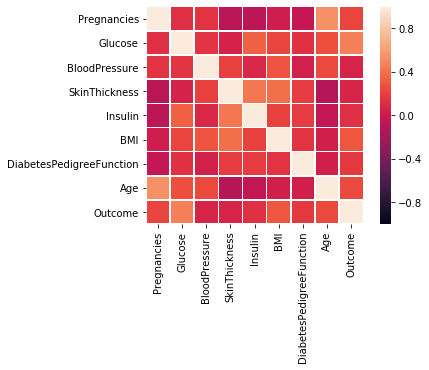

In [22]:
filled_cor_mat = pd.DataFrame(filled_data).corr()
sns.heatmap(cor_mat, vmin = -1, vmax = 1, linewidths = 0.5, square = True)

In [23]:
(cor_mat-filled_cor_mat)[abs(cor_mat-filled_cor_mat)>0.05]
#Есть ощущение, что я всё испортил

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,NaN,NaN,NaN,-0.202011,-0.138516,NaN,NaN,NaN,NaN
Glucose,NaN,NaN,NaN,-0.140996,-0.236090,NaN,NaN,NaN,NaN
BloodPressure,NaN,NaN,NaN,NaN,-0.050989,NaN,NaN,-0.054959,-0.067518
SkinThickness,-0.202011,-0.140996,NaN,NaN,0.241135,-0.269401,0.084755,-0.225663,-0.170994
Insulin,-0.138516,-0.236090,-0.050989,0.241135,NaN,NaN,0.086630,-0.272004,-0.197730
BMI,NaN,NaN,NaN,-0.269401,NaN,NaN,NaN,NaN,NaN
DiabetesPedigreeFunction,NaN,NaN,NaN,0.084755,0.086630,NaN,NaN,NaN,NaN
Age,NaN,NaN,-0.054959,-0.225663,-0.272004,NaN,NaN,NaN,NaN
Outcome,NaN,NaN,-0.067518,-0.170994,-0.197730,NaN,NaN,NaN,NaN


In [24]:
filled_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0.0
1,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1.0
2,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26.0,1.0
3,2.0,197.0,70.0,45.0,543.0,30.5,0.158,53.0,1.0
4,1.0,189.0,60.0,23.0,846.0,30.1,0.398,59.0,1.0


Забавно, что я увидел подпись "Заполните средними" в условии задания только после того, как сделал всё это. Но менять не буду, поскольку мне кажется, что заполненные таким образом пропуски будут гораздо более эффективны при решении задачи классификации, может быть из жалости получу какие-нибудь +0.03 бонусных балла :)

**2. (1 балл)** Визуализируйте распределение признаков по отдельности для больных диабетом и здоровых. Ваши графики должны быть примерно такими:

![Image](https://d.radikal.ru/d03/2005/f8/0ffb9443cbcf.png)

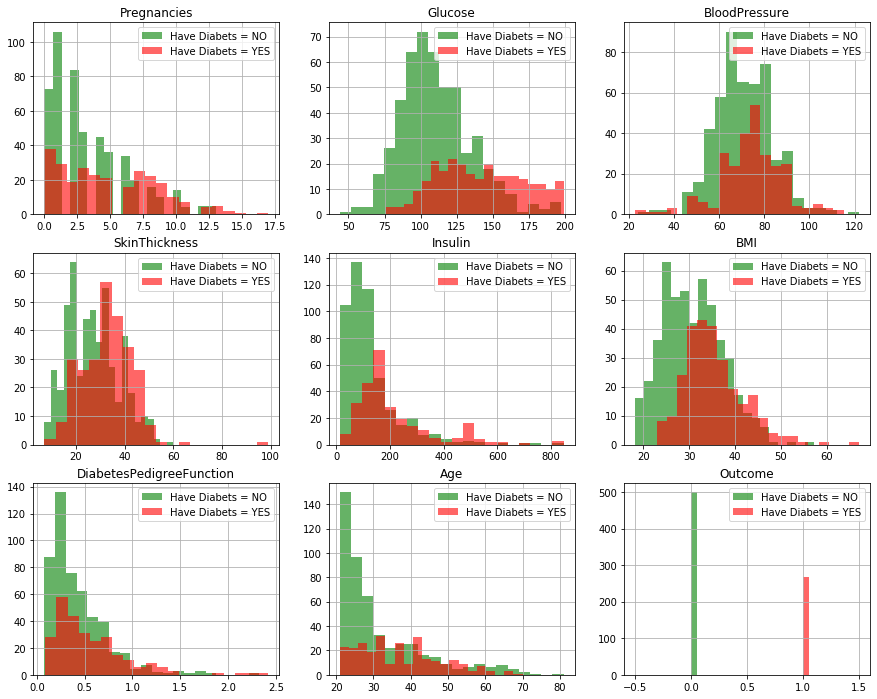

In [25]:
from math import log2

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

for i, name in enumerate(data.columns):
    ax[i//3][i%3].grid()
    ax[i//3][i%3].set_title('{}'.format(name))
    ax[i//3][i%3].hist(filled_data.loc[filled_data['Outcome'] == 0, name], alpha=0.6, color='green', histtype="barstacked",
            bins=int(1+log2(len(data))*2))
    ax[i//3][i%3].hist(filled_data.loc[filled_data['Outcome'] == 1, name], alpha=0.6, color='red', histtype="barstacked",
            bins=int(1+log2(len(data))*2))
    ax[i//3][i%3].legend(('Have Diabets = NO', 'Have Diabets = YES'))
plt.show()

**3. (2 балла)** Разбейте данные на обучающую и тестовую часть в соотношении 70:30. Обучите *BaggingClassifier* на деревьях (поставьте параметр *base_estimator = DecisionTreeClassifier()*) и *RandomForest*. Возьмите количество базовых алгоритмов, равное 10. Посчитайте accuracy, recall и precision. Есть ли какая-то разница между моделями и их результатами? Как вы думаете, почему получились такие результаты?

*tip: создайте отдельную функцию для вывода метрик качества;*

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [27]:
def metrics(y_test, y_pred):
    return [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)]

In [28]:
X = filled_data.drop('Outcome', axis=1)
y = filled_data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size=0.7, test_size=0.3)

In [31]:
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=10)
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
metrics(y_test, y_pred_bag)

[0.7575757575757576, 0.7241379310344828, 0.5121951219512195]

In [32]:
for_clf = RandomForestClassifier(n_estimators=10, random_state=10)
for_clf.fit(X_train, y_train)
y_pred_for = for_clf.predict(X_test)
metrics(y_test, y_pred_for)

[0.7922077922077922, 0.84, 0.5121951219512195]

Для обоих классификаторов качество по всем трём метрикам отклоняется друг от друга не более чем на 0.07, то есть разница в качестве не столь существенна. Также я обратил внимание на то, что если убрать параметр random_state, то accuracy & precision варьируются в диапазоне 0.65-0.85, а recall - в диапазоне 0.45-0.55. Это свидетельствует о значительном недообучении обоих моделей. 

Результаты весьма похожи, поскольку объектов в обучающей выборке всего около 600, а признаков всего 8 - разница между методом случайных подмножеств признаков для бутстрапированной выборки (forest) и регулярноым бустратоповым обновлением выборки со всеми признками (bag) может не стать слишком очевидной. 

In [33]:
norm_data = data
for i in col_names[1:6]:
    norm_data[i]=norm_data.loc[norm_data[i]!=0, i]
    norm_data[i] =  pd.to_numeric(norm_data[i], errors='coerce')
norm_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [34]:
for i in col_names[1:6]:
    norm_data[i] = norm_data[i].fillna(int(np.random.normal(loc=norm_data[i].mean(), scale=norm_data[i].std(), size=1)))

In [36]:
X1 = norm_data.drop('Outcome', axis=1)
y1 = norm_data['Outcome']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=10, train_size=0.7, test_size=0.3)

In [37]:
bag1_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=10)
bag1_clf.fit(X1_train, y1_train)
y1_pred_bag = bag1_clf.predict(X1_test)
metrics(y1_test, y1_pred_bag)

[0.7186147186147186, 0.6964285714285714, 0.4482758620689655]

In [38]:
for1_clf = RandomForestClassifier(n_estimators=10, random_state=10)
for1_clf.fit(X1_train, y1_train)
y1_pred_for = for1_clf.predict(X1_test)
metrics(y1_test, y1_pred_for)

[0.7316017316017316, 0.7049180327868853, 0.4942528735632184]

Возможно, куча потраченного на эффективное заполнение пропусков времени не было напрасным, поскольку каждая из метрик качества в случае обычного заполнения средними дала на 0.1 худшие результаты почти в каждом из случаев...

**4. (2 балл)** Для случайного леса проанализируйте значение ROC-AUC на этих же данных в зависимости от изменения параметров:
* *n_estimators* (можно перебрать около 10 значений из отрезка от 10 до 1500)
* *min_samples_leaf* (сетку значений можете выбрать на ваше усмотрение)

Постройте соответствующие графики зависимости ROC-AUC от этих параметров. Какие выводы можете сделать?

In [39]:
from sklearn.metrics import roc_auc_score

In [41]:
ii, jj = 0, 0
estimators = [10, 15, 20, 30, 50, 100, 200, 500, 1000, 1500]
leaves = [1, 3, 5, 7, 10, 12, 15, 18, 20, 30]
roc_auc_case = np.zeros(shape=(len(leaves), len(estimators)))
for i in leaves:
    for j in estimators:
        for_clf = RandomForestClassifier(n_estimators=j, random_state=10, min_samples_leaf=i)
        for_clf.fit(X_train, y_train)
        y_pred_for = for_clf.predict(X_test)
        roc_auc_case[leaves.index(i)][estimators.index(j)] = roc_auc_score(y_test, y_pred_for)

In [42]:
roc_auc_case

array([[0.72925192, 0.74631691, 0.72466852, 0.75241447, 0.74234736,
        0.74844492, 0.74508921, 0.74783107, 0.74508921, 0.74173351],
       [0.73776395, 0.73228024, 0.74508921, 0.75789818, 0.75454248,
        0.73350794, 0.74021935, 0.73076608, 0.73686364, 0.72741038],
       [0.71611557, 0.71521526, 0.72405467, 0.73412179, 0.7429612 ,
        0.73747749, 0.72741038, 0.71857096, 0.71857096, 0.7124734 ],
       [0.71460141, 0.7158291 , 0.72528237, 0.7124734 , 0.71795711,
        0.71857096, 0.71521526, 0.71857096, 0.71521526, 0.7091177 ],
       [0.72282698, 0.70302013, 0.70576199, 0.70576199, 0.70789   ,
        0.7158291 , 0.71308725, 0.70973154, 0.70637584, 0.70637584],
       [0.71185955, 0.69356687, 0.7091177 , 0.7091177 , 0.70973154,
        0.71644295, 0.70973154, 0.70973154, 0.70637584, 0.70637584],
       [0.69966443, 0.7124734 , 0.70027828, 0.70363398, 0.70027828,
        0.70363398, 0.70637584, 0.70637584, 0.70637584, 0.70637584],
       [0.72405467, 0.71308725, 0.7036339

In [43]:
roc_auc_case[:, estimators.index(1500)]

array([0.74173351, 0.72741038, 0.7124734 , 0.7091177 , 0.70637584,
       0.70637584, 0.70637584, 0.70363398, 0.70363398, 0.69815027])

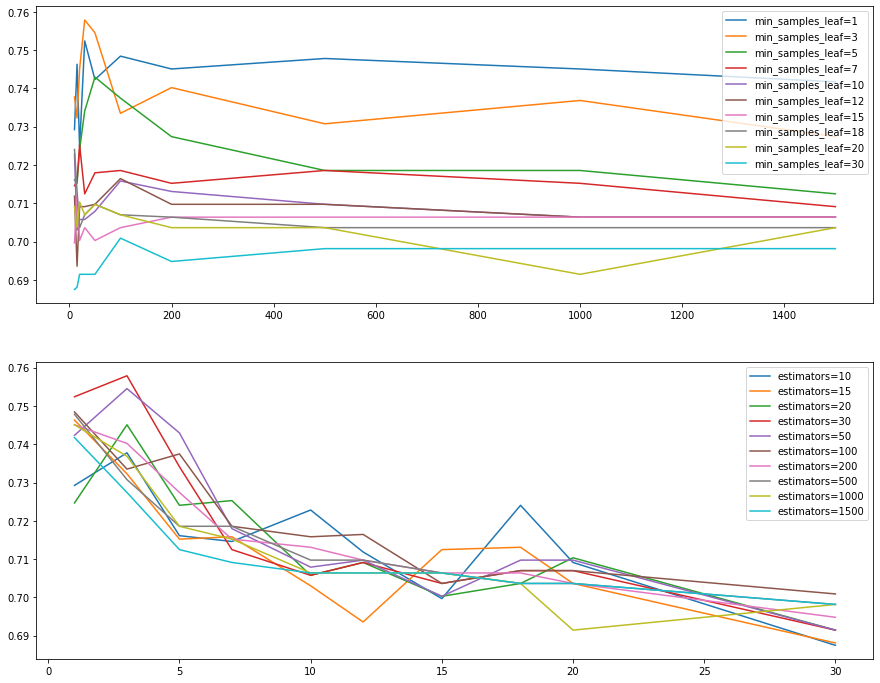

In [44]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

for i in leaves:
    ax[0].plot(estimators, roc_auc_case[leaves.index(i)], label="min_samples_leaf=%d"%(i,))
ax[0].legend(loc='upper right')

for j in estimators:
    ax[1].plot(leaves, roc_auc_case[:, estimators.index(j)], label="estimators=%d"%(j,))
ax[1].legend(loc='upper right')

На первом графике отображается зависимость качества от количества оценивающих деревьев и видно, что на отрезке [10, 100] достгиаются наибольшие показатели качества вне зависимости от количества листьев.

В свою очередь, на втором графике отображается зависимость качества классификатора от минимального количества значений в одном листе дерева, где прослеживается отрицательная корреляция между двумя этими показателями, поэтому можно сделать вывод, что следует брать 1, 3 или 10 листов для оптимальной работы классификатора.

In [50]:
np.where(roc_auc_case > 0.75)

(array([0, 1, 1], dtype=int64), array([3, 3, 4], dtype=int64))

Окидывая взглядом получившуюся матрицу, нам нужно 30 деревьев и как минимум 3 значения в одном листе для получения оптимального результата.

In [52]:
for_clf = RandomForestClassifier(n_estimators=30, random_state=10, min_samples_leaf=3)
for_clf.fit(X_train, y_train)
y_pred_for = for_clf.predict(X_test)
roc_auc_score(y_test, y_pred_for)

0.7578981830086757

**5. (1 балл)**. Посмотрите, оказались ли какие-то признаки более важными, чем остальные? Воспользуйтесь соответствующим аттрибутом случайного леса в библиотеке sklearn, чтобы построить barplot.

In [53]:
weights = for_clf.feature_importances_
weights

array([0.08054314, 0.26383046, 0.0582298 , 0.07919097, 0.14890705,
       0.15237502, 0.09801533, 0.11890822])

([<matplotlib.axis.XTick at 0x2d6aa74f940>,
 <a list of 8 Text xticklabel objects>)

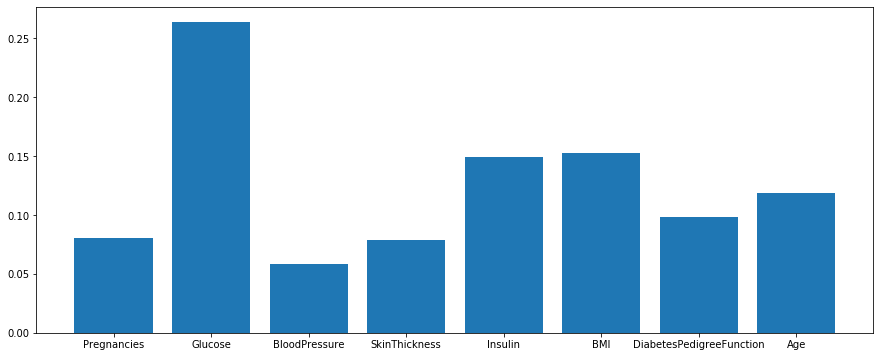

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
ax.bar(np.arange(8), weights)
plt.xticks(np.arange(8), col_names[0:8])

Наибольший вес в определении наличия у человека сахарного диабета имеет уровень глюкозы, инсулина в организме и его возраст, а также индекс массы тела.

**6. (2 балла)** Обучите HistGradientBoostingClassifier и GradientBoostingClassifier из sklearn. Опишите подробно, в чем заключается разница этих моделей. Подберите подходящее количество деревьев и проанализируйте метрики, с которыми мы работали выше.

In [55]:
from sklearn.experimental import enable_hist_gradient_boosting  #в sklearn сказали импортировать так
from sklearn.ensemble import HistGradientBoostingClassifier

HGB_clf = HistGradientBoostingClassifier()
HGB_clf.fit(X_train, y_train)
y_pred_for = HGB_clf.predict(X_test)
metrics(y_test, y_pred_for)

[0.7532467532467533, 0.676056338028169, 0.5853658536585366]

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

GB_clf = GradientBoostingClassifier()
GB_clf.fit(X_train, y_train)
y_pred_for = GB_clf.predict(X_test)
metrics(y_test, y_pred_for)

[0.7575757575757576, 0.7241379310344828, 0.5121951219512195]

При базовых значениях параметров качество обоих моделей крайне похоже (accuracy и вовсе одинаковая). 

Градиентный бустинг - это последовательное обучение моделей, где каждая новая корректирует ошибки предыдущей. Вычисление градиента для каждой модели будет показывать направление, в сторону которого следует обучать новую.  

HistGBClassifier отличается от обычного GBClassifier тем, что входные данные предварительно объединены в целочисленные ячейки, что значительно сокращает количество рассматриваемых точек разделения и позволяет алгоритму использовать структуры данных на основе целых чисел. Этот алгоритм более эффективен на огромных массивах данных, когда мы имеем дело с десятками тысяч наблюдений. В данной же задаче менее тысячи наблюдений, поэтому обычный градиентный бустинг должен стать более качественным в результате подбора оптимальных гиперпараметров для обеих моделей.

In [113]:
from sklearn.model_selection import GridSearchCV

In [123]:
grid_searcher_HGB = GridSearchCV(
    HGB_clf,
    param_grid={
        'max_leaf_nodes': [10, 30, 50, 100],
        'max_iter': [10, 20, 30, 50, 100], 
        'max_depth': [3, 5, 8, 10, 30],  
        'min_samples_leaf': [1, 2, 3, 5, 10], 
    },
    cv=2, n_jobs=-1
)
grid_searcher_HGB.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=HistGradientBoostingClassifier(l2_regularization=0.0,
                                                      learning_rate=0.1,
                                                      loss='auto', max_bins=256,
                                                      max_depth=None,
                                                      max_iter=100,
                                                      max_leaf_nodes=31,
                                                      min_samples_leaf=20,
                                                      n_iter_no_change=None,
                                                      random_state=None,
                                                      scoring=None, tol=1e-07,
                                                      validation_fraction=0.1,
                                                      verbose=0),
             iid='warn', n_jobs=-1,
             param_gr

In [124]:
grid_searcher_HGB.best_params_

{'max_depth': 3, 'max_iter': 20, 'max_leaf_nodes': 10, 'min_samples_leaf': 10}

In [125]:
metrics(grid_searcher_HGB.predict(X_test), y_test)

[0.7792207792207793, 0.5365853658536586, 0.7719298245614035]

Вспомнив про то, как долг происходила валидация в ДЗ2, я решил больше не ждать десятки часов и взял перебираемые параметры модели градиентного бустинга вот отсюда: https://stackoverflow.com/questions/58781601/parameter-tuning-using-gridsearchcv-for-gradientboosting-classifier-in-python

In [126]:
grid_searcher_GB = GridSearchCV(
    GB_clf,
    param_grid={
        "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10] 
    },
    cv=2, n_jobs=-1
)
grid_searcher_GB.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
       0.28181818, 0.31818182, 0.35454545, 0.39090909, 0.42727273,
 

In [127]:
grid_searcher_GB.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.13636363636363638,
 'min_samples_split': 0.17272727272727273,
 'n_estimators': 10,
 'subsample': 0.9}

In [128]:
metrics(grid_searcher_GB.predict(X_test), y_test)

[0.7575757575757576, 0.4878048780487805, 0.7407407407407407]

In [136]:
grid_searcher_GB = GridSearchCV(
    GB_clf,
    param_grid={
        "loss":["deviance"],
    "learning_rate": [0.2],
    "min_samples_split": [0.1727272],
    "min_samples_leaf": [0.1363636],
    "max_depth":[3],
    "max_features":["log2"],
    "criterion": ["friedman_mse"],
    "subsample":[0.9],
    "n_estimators":[5, 7, 10, 12, 15, 20, 30, 50, 100, 500, 1000] 
    },
    cv=2, n_jobs=-1
)
grid_searcher_GB.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no...
             iid='warn', n_jobs=-1,
             param_grid={'criter

In [137]:
grid_searcher_GB.best_params_

{'criterion': 'friedman_mse',
 'learning_rate': 0.2,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': 'log2',
 'min_samples_leaf': 0.1363636,
 'min_samples_split': 0.1727272,
 'n_estimators': 10,
 'subsample': 0.9}

In [138]:
metrics(grid_searcher_GB.predict(X_test), y_test)

[0.7532467532467533, 0.4634146341463415, 0.7450980392156863]

Таким образом, как ни странно, HGBClassifier оказался более эффективным в данном случае, выдав более качественные результаты по всем трём метрикам (accuracy, precision, recall).

**7. (1.5 балла)** Вспомните, что представляет собой [стэкинг моделей](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier). Возьмите в качестве базовых моделей любой ансамблевый метод из тех, которые были использованы выше, и простой классфикатор из уже вами изученных на курсе. Как final_estimator используйте лог-регресссию. Посчитайте метрики для мета-классификатора. Улучшилось ли качество?

In [141]:
#cannot import name 'StackingClassifier' from 'sklearn.ensemble'
pip install --upgrade scikit-learn
#Такой ошибки больше нет

  Found existing installation: scikit-learn 0.21.2
    Uninstalling scikit-learn-0.21.2:
      Successfully uninstalled scikit-learn-0.21.2


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Отказано в доступе: 'c:\\users\\481\\anaconda3\\lib\\site-packages\\~klearn\\decomposition\\cdnmf_fast.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



Note: you may need to restart the kernel to use updated packages.


In [57]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [58]:
estimators = [('rf', for_clf), 
    ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=10)))]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_clf.fit(X_train, y_train)
y_pred_stack = stack_clf.predict(X_test)
metrics(y_test, y_pred_stack)

C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

[0.7792207792207793, 0.7818181818181819, 0.524390243902439]

In [61]:
estimators = [('rf', for_clf), 
    ('svr', LinearSVC(random_state=10))]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_clf.fit(X_train, y_train)
y_pred_stack = stack_clf.predict(X_test)
metrics(y_test, y_pred_stack)

C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\481\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", Conve

[0.7662337662337663, 0.7916666666666666, 0.4634146341463415]

In [64]:
estimators = [('rf', for_clf), 
    ('HGB', HGB_clf), ('GB', GB_clf)]
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack_clf.fit(X_train, y_train)
y_pred_stack = stack_clf.predict(X_test)
metrics(y_test, y_pred_stack)

[0.7965367965367965, 0.7777777777777778, 0.5975609756097561]

Лучшая из моделей стекинга - последняя, обобщающая RandomForest, HistGradientBoosting и GradientBoosting [0.80, 0.78, 0.60], однако по показателю precision обыный RandomForest без стекинга даёт лучшие результаты [0.79, 0.84, ,0.51], что говорит о необходимости более тщательно и аккуратно подбирать ансамбли и модели для стекинга.

*tip: не забудьте завести список базовых алгоритмов*
<code>
base_learners = [
                 ('name1', model1(),
                 ('name2', model2())             
                ]

</code>